<a href="https://colab.research.google.com/github/Bilal-Ahmad-5/DAF/blob/main/DA'F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q pandas numpy tensorflow scikit-learn matplotlib seaborn transformers trl peft accelerate bitsandbytes tf-keras

In [2]:
import kagglehub, os, pandas as pd


# Download latest version
path = kagglehub.dataset_download("carrie1/ecommerce-data")

print("Path to dataset files:", path)

# List all files
for root, dirs, files in os.walk(path):
    for f in files:
        if f.endswith('.csv'):
            full_path = os.path.join(root, f)
            print(" -> Found CSV:", full_path)

# Choose the correct CSV file path above and load
file = full_path  # once identified
df = pd.read_csv(file, encoding='latin-1')
print("\nINFO:\n")
print(df.info())
print("\nDESCRIBE:\n")
print(df.describe())
print("\nSHAPE:\n")
print(df.shape)
print("\nCOLUMNS:\n")
print(df.columns)
print("\nDATA TYPES:\n")
print(df.dtypes)
print("\nUNIQUE VALUES:\n")
print(df.nunique())
print("\nHEAD:\n")
print(df.head())
print("\nTAIL\n:")
print(df.tail())

Path to dataset files: /kaggle/input/ecommerce-data
 -> Found CSV: /kaggle/input/ecommerce-data/data.csv

INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None

DESCRIBE:

            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         

In [3]:
print("NULL VALUES:")
print(df.isnull().sum())

# Remove rows where 'Description' is null
df.dropna(subset=['Description'], inplace=True)

print("\nNULL VALUES AFTER DROPPING NULL DESCRIPTIONS:")
print(df.isnull().sum())

NULL VALUES:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

NULL VALUES AFTER DROPPING NULL DESCRIPTIONS:
InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133626
Country             0
dtype: int64


In [4]:
# Fill missing values in 'CustomerID' with the mean of the column
mean_customer_id = df['CustomerID'].mean()
df['CustomerID'].fillna(mean_customer_id, inplace=True)

print("\nNULL VALUES AFTER FILLING CUSTOMERID WITH MEAN:")
print(df.isnull().sum())


NULL VALUES AFTER FILLING CUSTOMERID WITH MEAN:


/tmp/ipython-input-184006066.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['CustomerID'].fillna(mean_customer_id, inplace=True)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [5]:
# duplicate Values
print("Duplicate Values:")
print(df[df.duplicated()])

# Remove Duplicates
df.drop_duplicates(inplace=True)
print("\nDuplicate Values After Removal:")
print(df[df.duplicated()])

Duplicate Values:
       InvoiceNo StockCode                        Description  Quantity  \
517       536409     21866        UNION JACK FLAG LUGGAGE TAG         1   
527       536409     22866      HAND WARMER SCOTTY DOG DESIGN         1   
537       536409     22900    SET 2 TEA TOWELS I LOVE LONDON          1   
539       536409     22111       SCOTTIE DOG HOT WATER BOTTLE         1   
555       536412     22327  ROUND SNACK BOXES SET OF 4 SKULLS         1   
...          ...       ...                                ...       ...   
541675    581538     22068        BLACK PIRATE TREASURE CHEST         1   
541689    581538     23318     BOX OF 6 MINI VINTAGE CRACKERS         1   
541692    581538     22992             REVOLVER WOODEN RULER          1   
541699    581538     22694                       WICKER STAR          1   
541701    581538     23343       JUMBO BAG VINTAGE CHRISTMAS          1   

            InvoiceDate  UnitPrice  CustomerID         Country  
517     12/1/201

In [6]:
# Handle inconsistencies

# Remove rows with negative Quantity
df = df[df['Quantity'] > 0]

# Remove rows with negative UnitPrice
df = df[df['UnitPrice'] > 0]

# Remove rows where InvoiceNo starts with 'C' (cancellations)
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

print("Shape after handling inconsistencies:")
print(df.shape)

Shape after handling inconsistencies:
(524878, 8)


In [7]:
# Remove outliers using IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_cleaned

numerical_cols = ['Quantity', 'UnitPrice']

for col in numerical_cols:
    initial_shape = df.shape
    df = remove_outliers_iqr(df, col)
    print(f"Shape after removing outliers from {col}: {df.shape}")

print("\nShape after removing outliers from all numerical columns:")
print(df.shape)

Shape after removing outliers from Quantity: (497767, 8)
Shape after removing outliers from UnitPrice: (460251, 8)

Shape after removing outliers from all numerical columns:
(460251, 8)


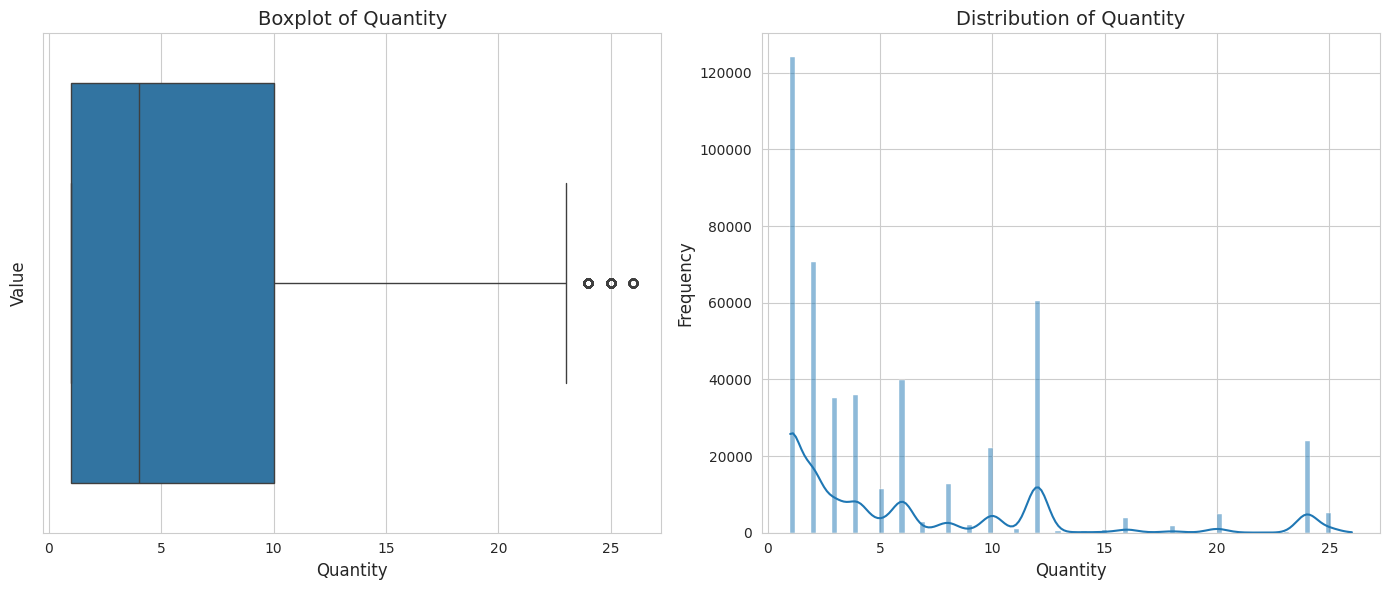

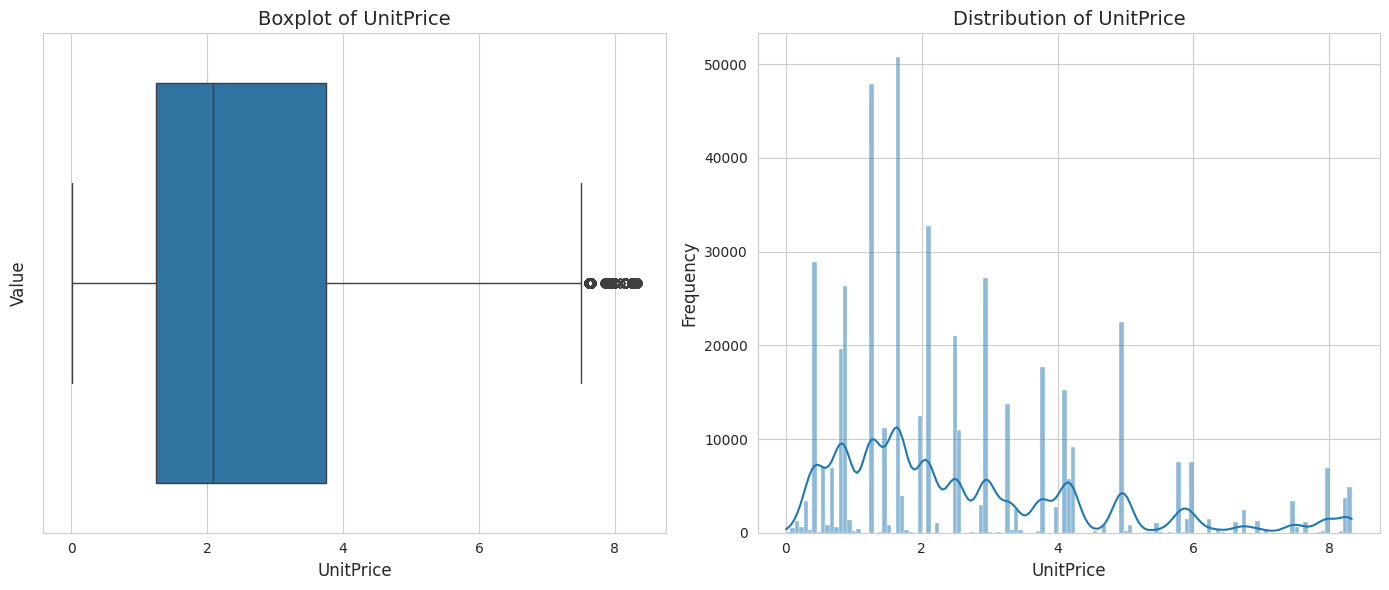

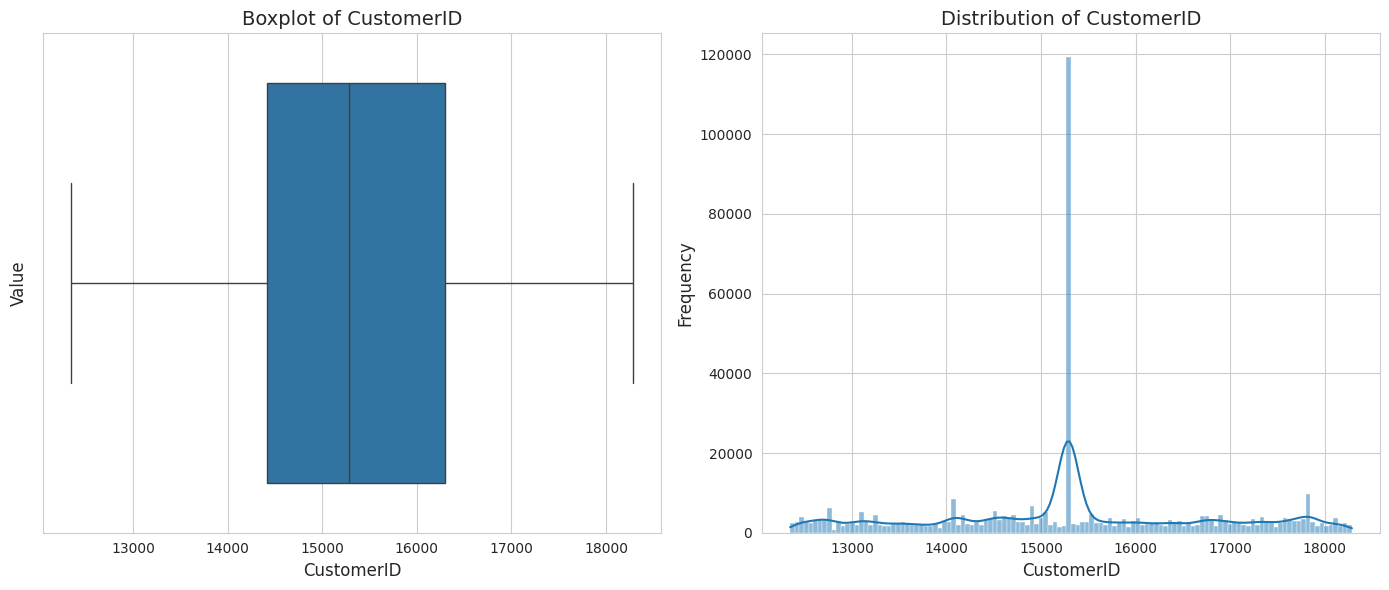

/tmp/ipython-input-2479255952.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], order=top_categories, palette='viridis')


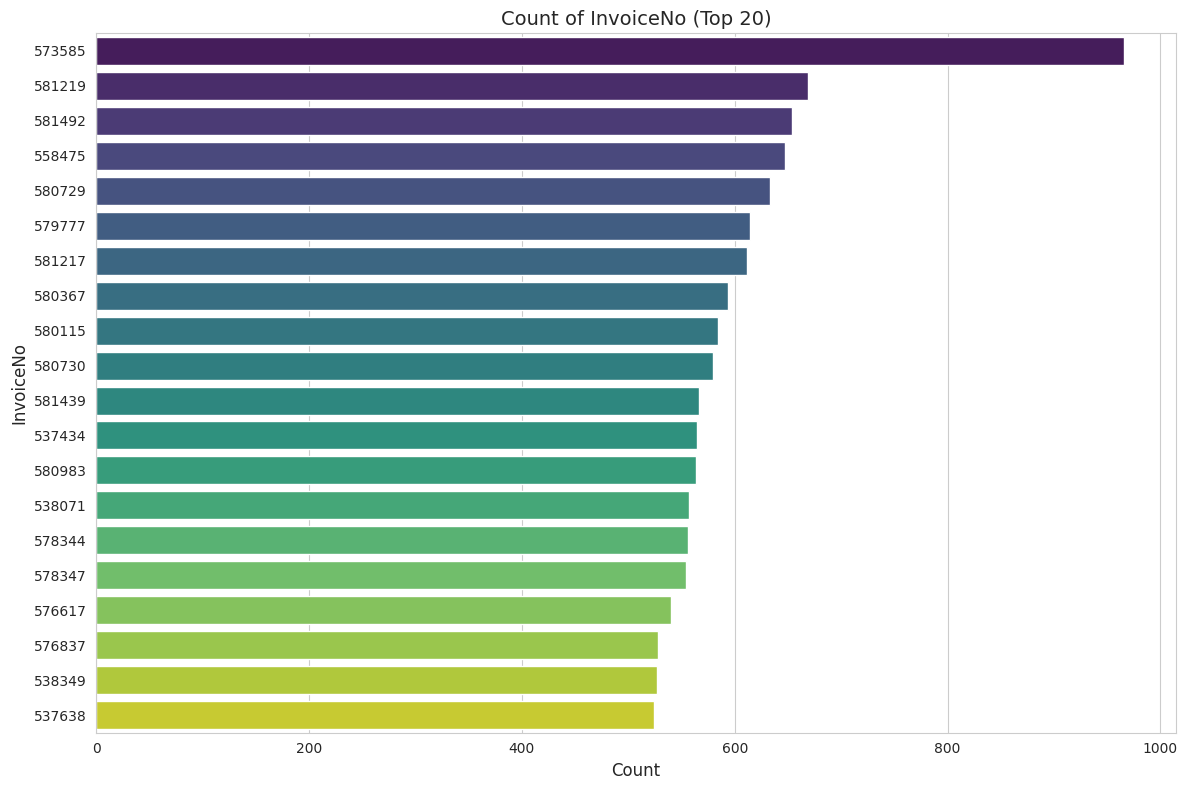

/tmp/ipython-input-2479255952.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], order=top_categories, palette='viridis')


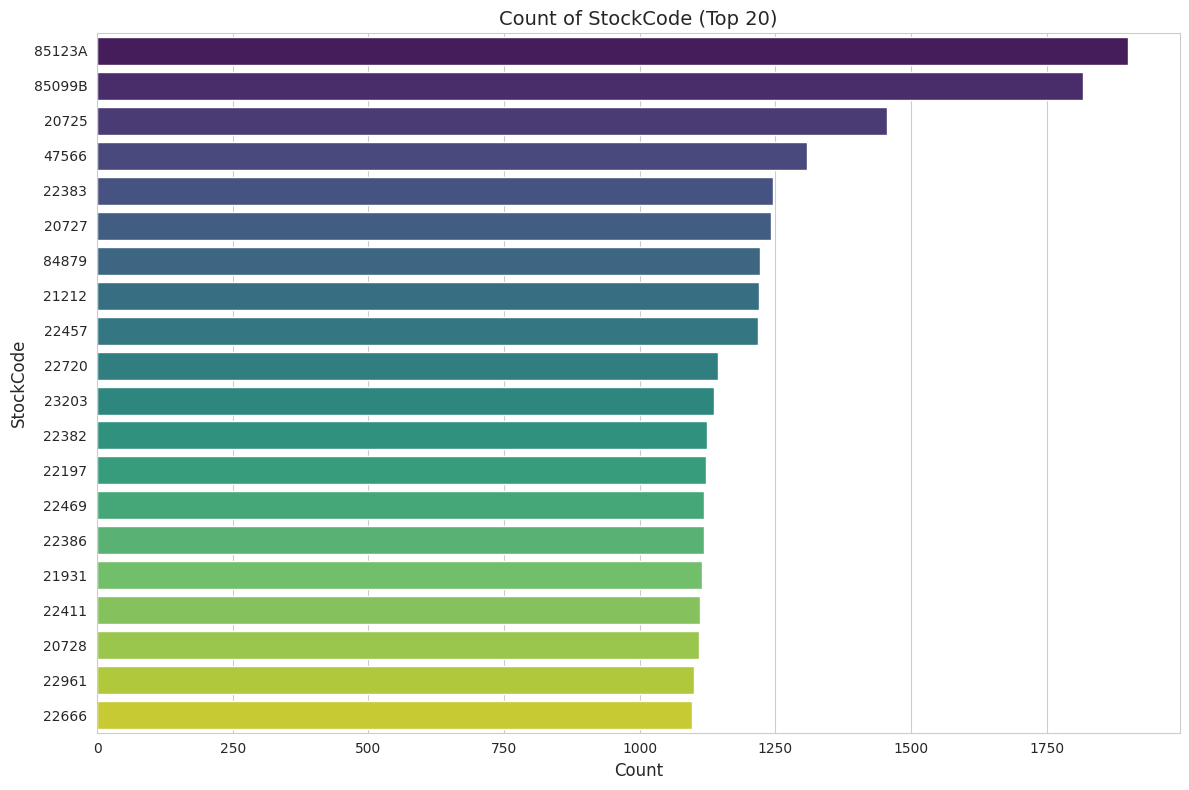

/tmp/ipython-input-2479255952.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], order=top_categories, palette='viridis')


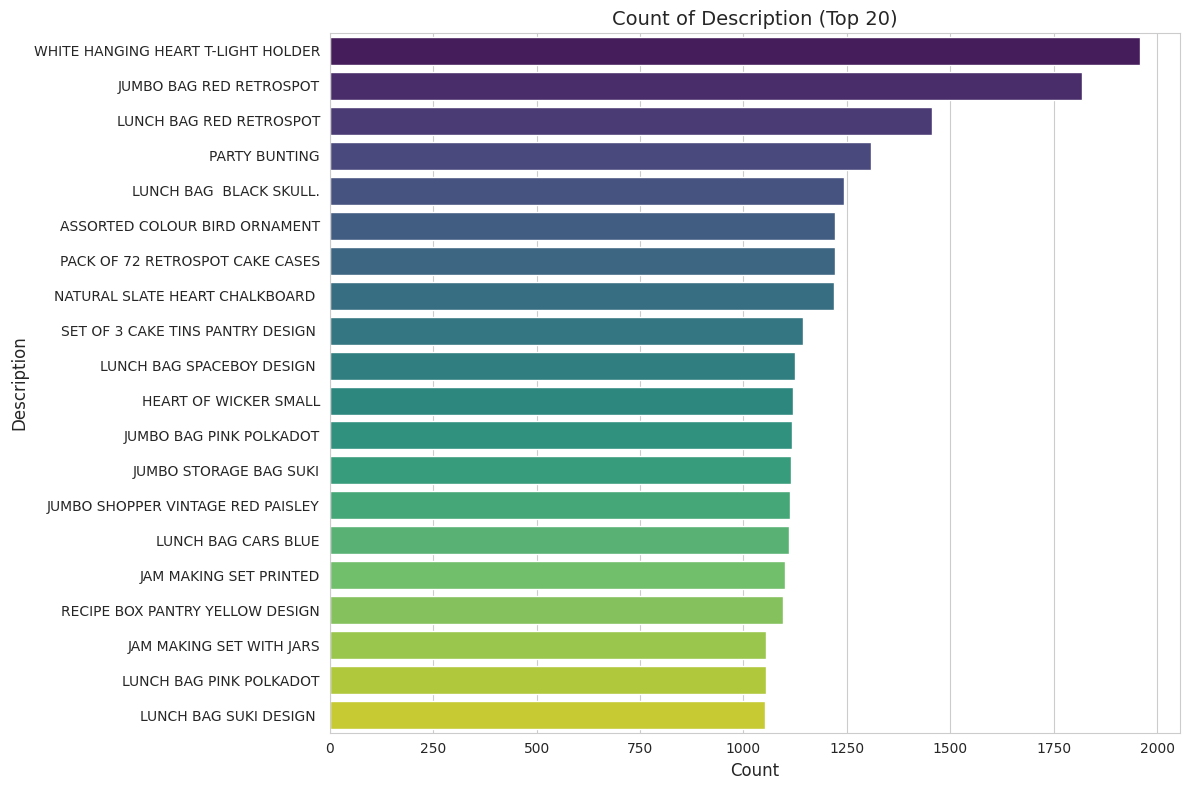

/tmp/ipython-input-2479255952.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], order=top_categories, palette='viridis')


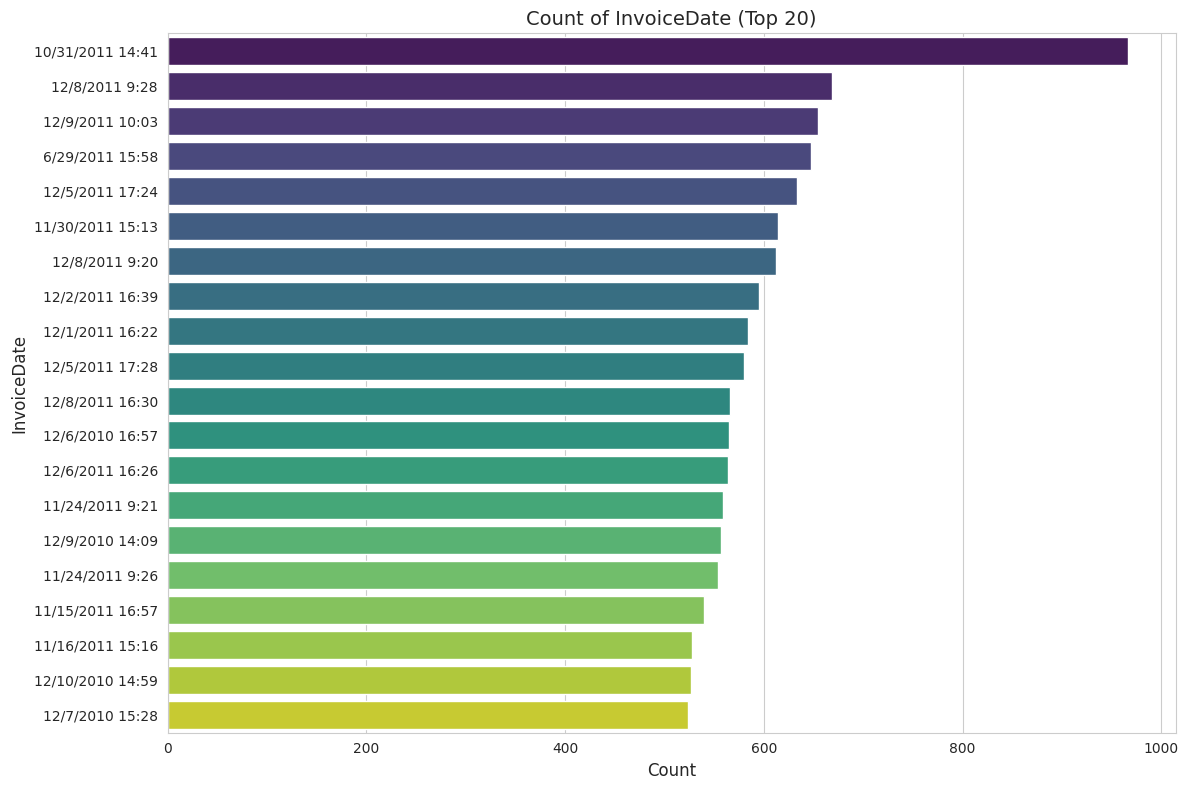

/tmp/ipython-input-2479255952.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], order=top_categories, palette='viridis')


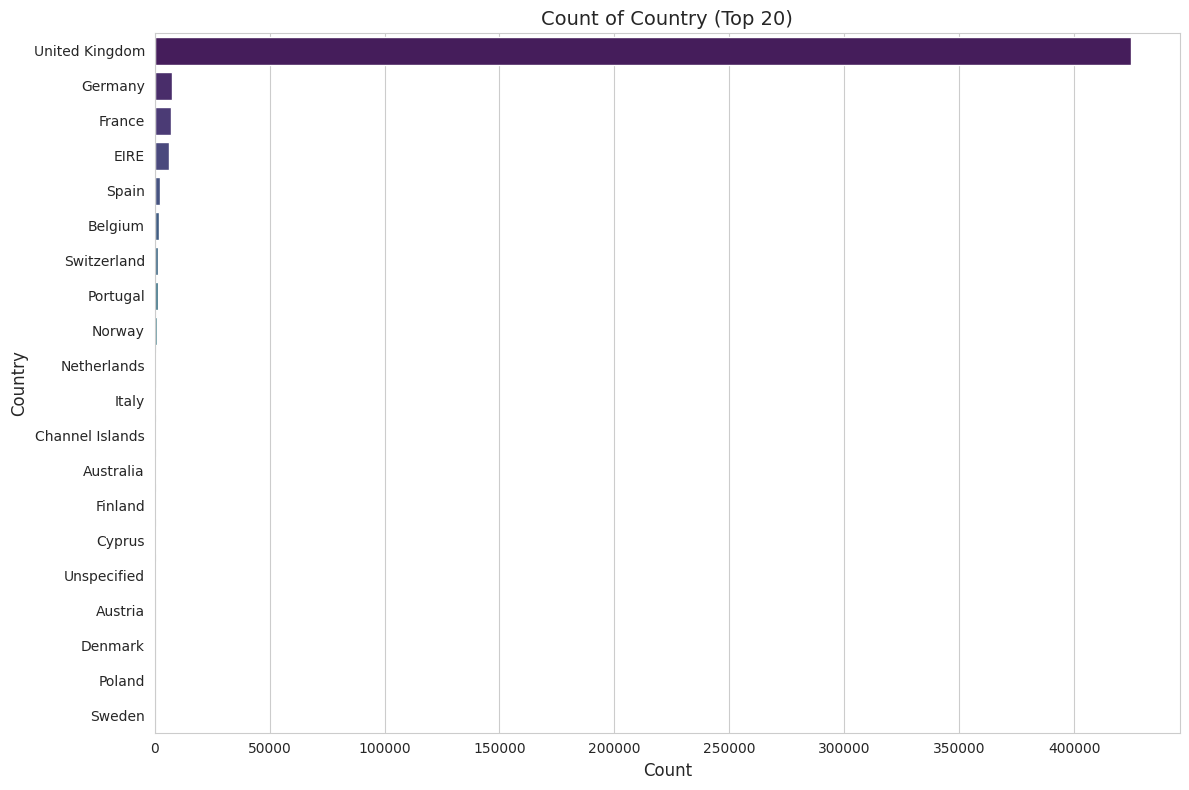

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set a style for the plots
sns.set_style("whitegrid")

# Get numerical and categorical columns
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(include='object').columns.tolist()

# Plot numerical columns
for col in numerical_cols:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6)) # Increased figure size for better readability

    # Boxplot
    sns.boxplot(x=df[col], ax=axes[0])
    axes[0].set_title(f'Boxplot of {col}', fontsize=14)
    axes[0].set_xlabel(col, fontsize=12)
    axes[0].set_ylabel('Value', fontsize=12)


    # Histplot
    sns.histplot(df[col], kde=True, ax=axes[1])
    axes[1].set_title(f'Distribution of {col}', fontsize=14)
    axes[1].set_xlabel(col, fontsize=12)
    axes[1].set_ylabel('Frequency', fontsize=12)


    plt.tight_layout()
    plt.show()

# Plot categorical columns
for col in categorical_cols:
    plt.figure(figsize=(12, 8)) # Increased figure size
    # Limit to top 20 categories for better readability
    top_categories = df[col].value_counts().nlargest(20).index
    sns.countplot(y=df[col], order=top_categories, palette='viridis')
    plt.title(f'Count of {col} (Top 20)', fontsize=14)
    plt.xlabel('Count', fontsize=12)
    plt.ylabel(col, fontsize=12)
    plt.tight_layout()
    plt.show()

In [9]:
import tensorflow as tf
from sklearn.model_selection import train_test_split


train_df, test_df = train_test_split(df, test_size=0.20, random_state=0)

train_df = train_df.sample(frac=0.01, random_state=0)
test_df = test_df.sample(frac=0.01, random_state=0)

print(train_df.shape)
print(test_df.shape)

(3682, 8)
(921, 8)


In [10]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

In [11]:
# The model that you want to train from the Hugging Face hub
model_name = "NousResearch/Llama-2-7b-chat-hf"

# Fine-tuned model name
new_model = "Batti-ai/Beepseek-R1"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "fp4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

In [12]:
# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type="fp4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)


# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map,
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Print the quantization config of the loaded model
print("Loaded model quantization config:")
print(model.config.quantization_config)


# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded model quantization config:
BitsAndBytesConfig {
  "_load_in_4bit": true,
  "_load_in_8bit": false,
  "bnb_4bit_compute_dtype": "float16",
  "bnb_4bit_quant_storage": "uint8",
  "bnb_4bit_quant_type": "fp4",
  "bnb_4bit_use_double_quant": false,
  "llm_int8_enable_fp32_cpu_offload": false,
  "llm_int8_has_fp16_weight": false,
  "llm_int8_skip_modules": null,
  "llm_int8_threshold": 6.0,
  "load_in_4bit": true,
  "load_in_8bit": false,
  "quant_method": "bitsandbytes"
}



In [13]:
from sklearn.model_selection import train_test_split

# Concatenate relevant columns into a single text column for tokenization
train_df['text'] = train_df['InvoiceNo'].astype(str) + " " + train_df['StockCode'].astype(str) + " " + train_df['Description'].astype(str) + " " + train_df['Quantity'].astype(str) + " " + train_df['InvoiceDate'].astype(str) + " " + train_df['UnitPrice'].astype(str) + " " + train_df['CustomerID'].astype(str) + " " + train_df['Country'].astype(str)
test_df['text'] = test_df['InvoiceNo'].astype(str) + " " + test_df['StockCode'].astype(str) + " " + test_df['Description'].astype(str) + " " + test_df['Quantity'].astype(str) + " " + test_df['InvoiceDate'].astype(str) + " " + test_df['UnitPrice'].astype(str) + " " + test_df['CustomerID'].astype(str) + " " + test_df['Country'].astype(str)

# Tokenize the 'text' column
train_encodings = tokenizer(train_df['text'].tolist(), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_df['text'].tolist(), truncation=True, padding=True, max_length=512)

In [14]:
from datasets import Dataset

# Create Hugging Face datasets from tokenized encodings
train_dataset = Dataset.from_dict(train_encodings)

# Test Data
test_dataset = Dataset.from_dict(test_encodings)

In [15]:
# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    peft_config=peft_config,
    args=training_arguments,
)

# Train model
trainer.train()

Truncating train dataset:   0%|          | 0/3682 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/921 [00:00<?, ? examples/s]

Step,Training Loss
25,3.376100
50,1.535200
75,1.157900
100,1.057200
125,1.007400
150,0.980100
175,0.945000
200,0.947400
225,0.915800
250,0.925100


TrainOutput(global_step=921, training_loss=0.9548264564572146, metrics={'train_runtime': 2896.8406, 'train_samples_per_second': 1.271, 'train_steps_per_second': 0.318, 'total_flos': 1.1590146854436864e+16, 'train_loss': 0.9548264564572146})

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
trainer.model.save_pretrained("/content/drive/MyDrive/bhatti-beepseek-r1")

In [22]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "InvoiceNo 536365 StockCode 85123A Description WHITE HANGING HEART T-LIGHT HOLDER Quantity 6"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

[INST] InvoiceNo 536365 StockCode 85123A Description WHITE HANGING HEART T-LIGHT HOLDER Quantity 6 [/INST]  Sure, here is the invoice for the items you purchased:
2023-03-14 14:40 123456789 United Kingdom
